# Overfitting
&nbsp; 과적합문제는 머신러닝이 직면한 가장 큰 문제 중 하나이다. 과적합이란 모형이 학습 데이터에만 적합하게 학습되어 학습 데이터 외의 다른 데이터가 들어오면 제대로 예측을 하지 못하는 현상을 말한다.


![image1](https://blogfiles.pstatic.net/MjAyMDAzMTdfMTUz/MDAxNTg0NDI2ODc2ODgz.OnEdxmvSfRaf_3erWvqBiKUCydGSNOkoF8x_SbQlX_sg.8rPsnM70Ov-jlOoE9WbQwPWSz1IsWbGVb3N1MnK3SD0g.JPEG.mint_vkkk/4.JPG?type=w2)

&nbsp; 위 그림의 가운데 그래프는 학습하고자 하는 모델의 가중치를 잘 찾 찾은 예시이다. Underfit 된 모형은 학습이 덜 된 모형을 말한다. 즉, 모형이 학습에 사용된 데이터조차 잘 설명하지 못한다고 볼 수 있다. 이와 반대로 Overfit된 모형은 학습에 사용된 데이터에 대해 학습을 너무 많이한 모형을 말한다. 이 경우 새로운 데이터가 주어질때 이를 적절히 평가하지 못하는 문제가 발생한다. 즉, overffing된 모형은 일반화가 안 된 모형이라고 할 수 있다. 


![image2](https://blogfiles.pstatic.net/MjAyMDAzMTdfNTIg/MDAxNTg0NDMzNjYxNjg3.zt58BaQCTmPg99-QjLHEjC2W2hgi4c-VNpLQHBs34_kg.Z_Na5dK7idqCheWlh1DxHHDIya5DsclxsoOsX1r7R8wg.JPEG.mint_vkkk/6.JPG?type=w2)

&nbsp; 위 그림은 학습이 진행될수록 모형의 정확도가 어떻게 변하는지를 설명한다. 일정 학습 수가 넘어가면 Test 데이터에 대한 정확도가 떨어짐을 볼 수 있다. 따라서 적절한 학습 수를 설정하는 것도 좋은 모델을 만들기 위해 중요한 요소라고 할 수 있다.


&nbsp; `Note 2. Linear Regression`에서는 잘 학습된 선형회귀모형을 볼 수 있었다. 이 노트에서는 학습을 더 시켜 Overfitting된 모형을 만들어 볼 것이다.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

np.random.seed(123457)

%matplotlib inline
plt.style.use('seaborn-whitegrid')
torch.set_printoptions(edgeitems=2)

In [2]:
# data
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]).unsqueeze(1)
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]).unsqueeze(1)

## Train_Validation Split

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 3,  8,  1, 10,  0,  7,  9,  6,  2]), tensor([5, 4]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
print(t_un_train.shape, t_un_val.shape)

torch.Size([9, 1]) torch.Size([2, 1])


## Define training_loop Functions

In [6]:
# training function

def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    history = {'train': [], 'val': []}
    
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        with torch.no_grad():
            t_p_val = model(t_u_val) # <1>
            loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f'Epoch {epoch:5d}, Training loss {float(loss_train):5f}, Validation loss {float(loss_val):5f}')

        history['train'].append(loss_train.item())
        history['val'].append(loss_val.item())
    #
    return history

## Define Model

In [7]:
class LinearTanh(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
            
        self.linear = nn.Linear(input_features, output_features)
        self.tanh = nn.Tanh()
        
    def forward(self, layer_input):
        layer_linear = self.linear(layer_input)
        layer_output = self.tanh(layer_linear)
        return layer_output

In [8]:
class SubclassModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Hidden_1 = LinearTanh(1, 11)
        self.Hidden_2 = LinearTanh(11, 21)
        self.Hidden_3 = LinearTanh(21, 31)
        self.Hidden_4 = LinearTanh(31, 41)
        self.Hidden_5 = LinearTanh(41, 51)
        self.Output = nn.Linear(51, 1)
        
    def forward(self, input):
        Hidden_1 = self.Hidden_1(input)
        Hidden_2 = self.Hidden_2(Hidden_1)
        Hidden_3 = self.Hidden_3(Hidden_2)
        Hidden_4 = self.Hidden_4(Hidden_3)
        Hidden_5 = self.Hidden_5(Hidden_4)
        Output = self.Output(Hidden_5)
        
        return Output

In [9]:
myModel = SubclassModel()
myModel

SubclassModel(
  (Hidden_1): LinearTanh(
    (linear): Linear(in_features=1, out_features=11, bias=True)
    (tanh): Tanh()
  )
  (Hidden_2): LinearTanh(
    (linear): Linear(in_features=11, out_features=21, bias=True)
    (tanh): Tanh()
  )
  (Hidden_3): LinearTanh(
    (linear): Linear(in_features=21, out_features=31, bias=True)
    (tanh): Tanh()
  )
  (Hidden_4): LinearTanh(
    (linear): Linear(in_features=31, out_features=41, bias=True)
    (tanh): Tanh()
  )
  (Hidden_5): LinearTanh(
    (linear): Linear(in_features=41, out_features=51, bias=True)
    (tanh): Tanh()
  )
  (Output): Linear(in_features=51, out_features=1, bias=True)
)

## Trainig & Plotting

In [10]:
optimizer = optim.Adam(myModel.parameters(), lr=1e-4)
loss = nn.MSELoss()

hist = training_loop(n_epochs = 15000, 
                     optimizer = optimizer,
                     model = myModel,
                     loss_fn = loss,
                     t_u_train = t_un_train,
                     t_u_val = t_un_val, 
                     t_c_train = t_c_train,
                     t_c_val = t_c_val)

Epoch     1, Training loss 211.541016, Validation loss 95.234596
Epoch  1000, Training loss 98.204659, Validation loss 3.161988
Epoch  2000, Training loss 93.526283, Validation loss 3.128633
Epoch  3000, Training loss 38.352383, Validation loss 3.223149
Epoch  4000, Training loss 15.752470, Validation loss 3.707956
Epoch  5000, Training loss 6.740075, Validation loss 1.741871
Epoch  6000, Training loss 3.246992, Validation loss 2.358732
Epoch  7000, Training loss 1.257250, Validation loss 5.005960
Epoch  8000, Training loss 0.806394, Validation loss 5.241268
Epoch  9000, Training loss 0.604093, Validation loss 4.852153
Epoch 10000, Training loss 0.565214, Validation loss 4.745380
Epoch 11000, Training loss 0.508493, Validation loss 4.712446
Epoch 12000, Training loss 0.372076, Validation loss 4.739616
Epoch 13000, Training loss 0.284291, Validation loss 4.747952
Epoch 14000, Training loss 0.222962, Validation loss 5.070446
Epoch 15000, Training loss 0.028701, Validation loss 7.279340


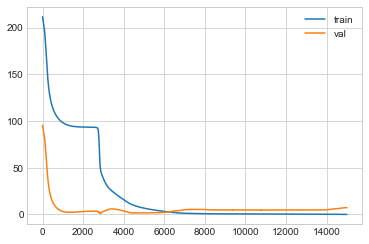

In [16]:
plt.plot(hist['train'], label='train')
plt.plot(hist['val'], label='val')
plt.legend()

 validation loss가 14000 epoch 이후 증가하는 것이 보인다.

In [17]:
def plot_result():
    t_range = torch.arange(20., 90.).unsqueeze(1)
    
    plt.plot(t_u_val.numpy(), t_c_val.numpy(), 'o', label='data: tr+val')
    plt.plot(t_u_train.numpy(), t_c_train.numpy(), 'go', label='data: train')
    plt.plot(t_range.numpy(), myModel(0.1 * t_range).detach().numpy(), 'c-', label='prediction')
    plt.plot(t_u_train.numpy(), myModel(t_un_train).detach().numpy(), 'kx')
    plt.plot(t_u_val.numpy(), myModel(t_un_val).detach().numpy(), 'rx', label='validation')
    plt.xlabel("Fahrenheit")
    plt.ylabel("Celsius")
    
    plt.legend()

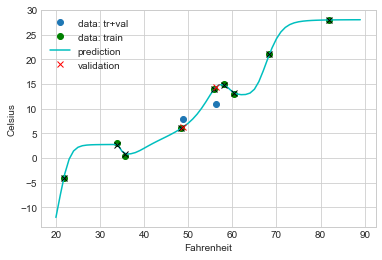

In [18]:
plot_result()

## Accessing to Weights and Bias

In [14]:
for name, param in myModel.named_parameters():
    print(name, param.shape)

Hidden_1.linear.weight torch.Size([11, 1])
Hidden_1.linear.bias torch.Size([11])
Hidden_2.linear.weight torch.Size([21, 11])
Hidden_2.linear.bias torch.Size([21])
Hidden_3.linear.weight torch.Size([31, 21])
Hidden_3.linear.bias torch.Size([31])
Hidden_4.linear.weight torch.Size([41, 31])
Hidden_4.linear.bias torch.Size([41])
Hidden_5.linear.weight torch.Size([51, 41])
Hidden_5.linear.bias torch.Size([51])
Output.weight torch.Size([1, 51])
Output.bias torch.Size([1])


In [15]:
print(f'Weight : {myModel.Output.weight}')
print(f'Bias : {myModel.Output.bias}')

Weight : Parameter containing:
tensor([[-0.5315, -0.5369, -0.5659, -0.6129, -0.5550,  0.6183, -0.5697,  0.5037,
          0.6448, -0.9983, -0.5619,  0.5731, -0.6797, -0.5508,  0.5916, -0.6398,
          0.6876,  0.5324, -0.6298,  0.6126,  0.4861, -0.5966,  0.5971, -0.4993,
          0.5674, -0.5373,  0.5819,  0.6482,  0.6392,  0.6115, -0.6071, -0.5924,
         -0.5477, -0.5871, -0.5117,  0.5412,  0.6684,  0.6258,  0.5030,  0.5897,
         -0.5858, -0.4980, -0.5213,  0.7415,  0.6723,  0.5760, -0.6594, -0.6045,
          0.5581, -0.6198, -0.5877]], requires_grad=True)
Bias : Parameter containing:
tensor([0.4663], requires_grad=True)
